## Machine Learning Model Building Pipeline: Wrapping up for Deployment


In the previous sections, we worked through the typical Machine Learning pipeline to build a regression model that allows us to predict house prices. We have done exploratory data analysis to udnerstand the data, then modified them to make them suitable for regression model and we have selected a subset of variables using Lasso regression.

Now, we need to deploy out model so that when we call new data, our model will be able to estimate the SalePrice based on the characeristics of the house. For this, the code needs to be modified to be suitable and will be shown next. In this section, we will summarise the key parts of the code which will go into the production.

### Setting the seed to ensure reproducibility

It is important to note, that since we are engineering variables and pre-processing data with the idea of deploying the model we need to ensure reproucibility. Hence for each step that includes some element of randomness, it is important that we set the seed.

In [121]:
# To handle datasets. These are standard imports
import pandas as pd
import numpy as np
import os

# for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# to display data with high width
pd.set_option('display.width', 1000)

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import Lasso

# to evaluate the models
from sklearn.metrics import mean_squared_error
from math import sqrt

# to persist the model and the scaler
from sklearn.externals import joblib

## Load data

We need the training data to train our model in the production environment. 

In [122]:
# Make the output of notebook stable across runs by setting randon seed
np.random.seed(42)

# To make the pictures pretty
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Set up directories to work with datasets and images
PROJECT_ROOT_DIR = os.getcwd()
DATASET_FOLDER = "DataSets"    # Data goes into the DataSets folder
IMAGES_FOLDER = "IMAGES"       # Images go into IMAGES folder

DATASET_PATH = os.path.join(PROJECT_ROOT_DIR, DATASET_FOLDER)
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, IMAGES_FOLDER)

def load_data(filename, dataset_path=DATASET_PATH,**kwargs):
    """Helper Function to load data. Inputs are file name and directory where datasets are stored"""
    file_with_path = os.path.join(dataset_path, filename)
    return pd.read_csv(file_with_path,**kwargs)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Helper Function to save data. Inputs are file name and directory where datasets are stored"""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [123]:
# load dataset
data = load_data(filename="Housing_Data.csv")
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Separate dataset into train and test

Before beginning to engineer our features, it is important to separate our data intro training and testing set. This is to avoid over-fitting. There is an element of randomness in dividing the dataset, so remember to set the seed.

In [124]:
# Let's separate into train and test set
# Remember to seet the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(data, data.SalePrice,
                                                    test_size=0.1,
                                                    random_state=0) # we are setting the seed here
X_train.shape, X_test.shape

((1314, 81), (146, 81))

## Selected features

Remember that we will deploy our model utilising only a subset of features, the most predictive ones. This is to make simpler models, so that we build simpler code for deployment.

In [125]:
# load selected features
features = load_data(filename="selected_features.csv", header=None)

# We can add extra features if needed like the line below
features = [x for x in features[0]] + ['LotFrontage']

print(f'Number of selected features: {len(features)}')

Number of selected features: 23


In [126]:
print(features)

['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Functional', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'GarageYrBlt_na', 'LotFrontage']


In [127]:
# 'GarageYrBlt_na' is still needed
print(features)

['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Functional', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'GarageYrBlt_na', 'LotFrontage']


## Missing Categorical variable values

Let's work with the missing categorical variables first. Now we have lesser or no categorical variables with missing values in comparison to our original dataset. But we still use categorical variables with NA for the final model, so we need to include this piece of feature engineering logic in the deployment pipeline. 

In [128]:
[var for var in data.columns if data[var].dtypes=='O' and var in features]

['MSZoning', 'LotShape', 'Functional']

In [129]:
# make a list of the numerical variables that contain missing values
catvars_with_na = [var for var in data.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes=='O' and var in features]

# print the variable name and the percentage of missing values
if catvars_with_na:
    for var in catvars_with_na:
        print(var, np.round(X_train[var].isnull().mean(), 3),  ' % missing values')
else:
    print(f"No categorical variables with missing values")

No categorical variables with missing values


For categorical variables, we will fill missing information by adding an additional category: "blank"

In [130]:
# function to replace NA in categorical variables
def fill_categorical_na(df, var_list, missing_str='Blank'):
    """Helper function to replace missing values in a variable with given string or value"""
    X = df.copy()
    X[var_list] = df[var_list].fillna(missing_str)
    return X

# replace missing values with new label: "Blank"
X_train = fill_categorical_na(X_train, catvars_with_na, 'Blank')
X_test = fill_categorical_na(X_test, catvars_with_na, 'Blank')

# check that we have no missing information in the engineered categorical variables
X_train[catvars_with_na].isnull().sum()

Series([], dtype: float64)

## Numerical Variable Transformation

For numerical variables, we are going to add an additional variable capturing the missing information, and then replace the missing information in the original variable by the mode (Most frequently occuring value). Lets work on numerical variables now. Before that, we need to create the additional variable **"GarageYrBlt_na"** which is missing in the dataset but is selected as one of the feature

In [131]:
print([var for var in data.columns if data[var].dtypes!='O' and var in features])

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch']


In [132]:
# make a list of the numerical variables that contain missing values (If selected as a feature)
numvars_with_na = [var for var in data.columns if X_train[var].isnull().sum()>1 and X_train[var].dtypes!='O']
print(numvars_with_na)
# print the variable name and the percentage of missing values
if numvars_with_na:
    for var in numvars_with_na:
        print(var, np.round(X_train[var].isnull().mean(), 3),  ' % missing values')
else:
    print(f"No numerical variables have missing values")

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
LotFrontage 0.177  % missing values
MasVnrArea 0.005  % missing values
GarageYrBlt 0.056  % missing values


In [133]:
# replace missing values and create a new variable to show the missing rows

def fill_vars_na(vars_with_na, repl_type="mode"):
    for var in vars_with_na:

        if repl_type=="mode":
            repl_val = X_train[var].mode()[0]
        elif repl_type=="mean":
            repl_val = X_train[var].mean()
        else:
            raise exception("The input argument Repl_type not correctly set")

        # train
        X_train[var+'_na'] = np.where(X_train[var].isnull(), 1, 0)
        X_train[var].fillna(repl_val, inplace=True)

        # test
        X_test[var+'_na'] = np.where(X_test[var].isnull(), 1, 0)
        X_test[var].fillna(repl_val, inplace=True)

fill_vars_na(numvars_with_na, repl_type="mode")  # Fill the missing values with the mode of the column

#### Important: persisting the mean value for NA imputation

As you will see in future sections, one of the key pieces of deploying the model is "Model Validation". Model validation refers to corroborating that the deployed model and the model built during research, are identical. Since, there are likely to have been several experiments during research, we need to ensure that the entire pipeline both in production and validation state produce same results.

Therefore, in order to check at the end of the process that the feature engineering pipelines are identical, we will save (we will persist), the mean value of the variable, so that we can use it at the end, and corroborate our models.

In [134]:
# replace the missing values

mean_var_dict = {}

for var in numvars_with_na:
    
    # calculate the mode
    mode_val = X_train[var].mode()[0]
    
    # we persist the mean in the dictionary
    mean_var_dict[var] = mode_val
    
    # train
    X_train[var].fillna(mode_val, inplace=True)
    
    # test
    X_test[var].fillna(mode_val, inplace=True)

# we save the dictionary for later
np.save('mean_var_dict.npy', mean_var_dict)

# check that we have no more missing values in the engineered variables
X_train[numvars_with_na].isnull().sum()
mean_var_dict

{'LotFrontage': 60.0, 'MasVnrArea': 0.0, 'GarageYrBlt': 2005.0}

### Temporal variables

One of our temporal variables was selected to be used in the final model: 'YearRemodAdd'

So we need to deploy the bit of code that creates it.

In [135]:
# create the temporal var "elapsed years"
def elapsed_years(df, var):
    # capture difference between year variable and year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [136]:
X_train = elapsed_years(X_train, 'YearRemodAdd')
X_test = elapsed_years(X_test, 'YearRemodAdd')

### Numerical variables (Log Transformation)

We will log transform the numerical variables that do not contain zeros in order to get a more Gaussian-like distribution. This tends to help Linear machine learning models.

In [137]:
def transform_cols(varlist):
    for var in varlist:
        X_train[var] = np.log(X_train[var])
        X_test[var]= np.log(X_test[var])
           
transform_cols(['LotFrontage', 'LotArea', '1stFlrSF', 'GrLivArea', 'SalePrice'])

### Categorical variables: rare label creation

We do have categorical variables in our final model. First, we will remove those categories within variables that are present in less than 1% of the observations:

In [138]:
# let's capture the categorical variables first
cat_vars = [var for var in features if X_train[var].dtype == 'O']
print(cat_vars)

['MSZoning', 'LotShape', 'Functional']


#### Important: persisting the frequent labels

As you will see in future sections, one of the key pieces of deploying the model is "Model Validation". Model validation refers to corroborating that the deployed model and the model built during research, are identical. The entire pipeline needs to produce identical results.

Therefore, in order to check at the end of the process, that the feature engineering pipelines are identical, we will save -we will persist-, the list of frequent labels per variable, so that we can use it at the end, to corroborate our models.

In [139]:
def find_frequent_labels(df, var, rare_perc):
    # finds the labels that are shared by more than a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp>rare_perc].index

In [140]:
frequent_ls = find_frequent_labels(X_train, "MSZoning", 0.05)
frequent_ls

Index(['RL', 'RM'], dtype='object', name='MSZoning')

In [141]:
def find_frequent_labels(df, var, rare_perc):
    # finds the labels that are shared by more than a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)['SalePrice'].count() / len(df)
    return tmp[tmp>rare_perc].index

frequent_labels_dict = {}

for var in cat_vars:
    frequent_ls = find_frequent_labels(X_train, var, 0.8)
    
    # we save the list in a dictionary
    frequent_labels_dict[var] = frequent_ls
    
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')
    
# now we save the dictionary
np.save('FrequentLabels.npy', frequent_labels_dict)

In [142]:
frequent_labels_dict

{'MSZoning': Index([], dtype='object', name='MSZoning'),
 'LotShape': Index([], dtype='object', name='LotShape'),
 'Functional': Index(['Typ'], dtype='object', name='Functional')}

In [143]:
# def find_rare_labels(df, var, rare_perc):
#     # finds the labels that are shared by less than a certain % of rows in the dataset
#     df = df.copy()
#     tmp = df.groupby(var)['SalePrice'].count() / len(df)
#     return tmp[tmp<rare_perc].index

# rare_labels_dict = {}

# for var in cat_vars:
#     rare_ls = find_rare_labels(X_train, var, 0.01)
#     # we save the list in a dictionary
#     rare_labels_dict[var] = frequent_ls
#     X_train[var] = np.where(X_train[var].isin(rare_ls), X_train[var], 'Rare')
#     X_test[var] = np.where(X_test[var].isin(rare_ls), X_test[var], 'Rare')
    
# # now we save the dictionary
# np.save('RareLabels.npy', rare_labels_dict)
# rare_labels_dict

In [144]:
# rare_labels_dict

Next, we need to transform the strings of these variables into numbers. We will do it so that we capture the monotonic relationship between the label and the target:

In [145]:
# this function will assign discrete values to the strings of the variables, so that the smaller value corresponds to the smaller mean of target

def replace_categories(df, var, target): 
    ordered_labels = df.groupby([var])[target].mean().sort_values().index
    ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
    df[var] = df[var].map(ordinal_label)   
    return df[var]

In [146]:
ordinal_label_dict = {}
for var in cat_vars:
    X_train[var] = replace_categories(X_train, var, 'SalePrice')
    X_test[var] = replace_categories(X_test, var, 'SalePrice')
    
# now we save the dictionary
# np.save('OrdinalLabels.npy', ordinal_label_dict)

In [147]:
# # this function will assign discrete values to the strings of the variables, so that the smaller value corresponds to the smaller mean of target

# def replace_categories(train, test, var, target):
#     train = train.copy()
#     test = test.copy()
    
#     ordered_labels = train.groupby([var])[target].mean().sort_values().index
#     ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
    
#     train[var] = train[var].map(ordinal_label)
#     test[var] = test[var].map(ordinal_label)
    
#     return ordinal_label, train, test

In [148]:
# ordinal_label_dict = {}
# for var in cat_vars:
#     ordinal_label, X_train, X_test = replace_categories(X_train, X_test, var, 'SalePrice')
#     ordinal_label_dict[var] = ordinal_label
    
# # now we save the dictionary
# np.save('OrdinalLabels.npy', ordinal_label_dict)

In [149]:
ordinal_label_dict

{}

In [150]:
# check absence of na
[var for var in features if X_train[var].isnull().sum()>0]

[]

In [151]:
# check absence of na
[var for var in features if X_test[var].isnull().sum()>0]

[]

### Feature Scaling

For use in linear models, features need to be either scaled or normalised. In the next section, I will scale features between the min and max values:

In [152]:
print(features)

['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'Functional', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'GarageYrBlt_na', 'LotFrontage']


In [153]:
# capture the target
y_train = X_train['SalePrice']
y_test = X_test['SalePrice']

In [154]:
# fit scaler
scaler = MinMaxScaler() # create an instance
scaler.fit(X_train[features]) #  fit  the scaler to the train set for later use

# we persist the model for future use
joblib.dump(scaler, 'scaler.pkl')

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


['scaler.pkl']

In [155]:
# transform the train and test set, and add on the Id and SalePrice variables
X_train = pd.DataFrame(scaler.transform(X_train[features]), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test[features]), columns=features)

In [156]:
# train the model
lin_model = Lasso(alpha=0.005, random_state=0) # remember to set the random_state / seed
lin_model.fit(X_train, y_train)

# we persist the model for future use
joblib.dump(lin_model, 'lasso_regression.pkl')

['lasso_regression.pkl']

In [157]:
# evaluate the model:
# remember that we log transformed the output (SalePrice) in our feature engineering notebook / lecture.

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and the
# root of the mean squared error

pred = lin_model.predict(X_train)
print('linear train mse: {}'.format(mean_squared_error(np.exp(y_train), np.exp(pred))))
print('linear train rmse: {}'.format(sqrt(mean_squared_error(np.exp(y_train), np.exp(pred)))))
print()
pred = lin_model.predict(X_test)
print('linear test mse: {}'.format(mean_squared_error(np.exp(y_test), np.exp(pred))))
print('linear test rmse: {}'.format(sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))))
print()
print('Average house price: ', np.exp(y_train).median())

linear train mse: 1311097338.457859
linear train rmse: 36209.0781221762

linear test mse: 1422327230.7941039
linear test rmse: 37713.75386770858

Average house price:  163000.00000000012


(100, 450000)

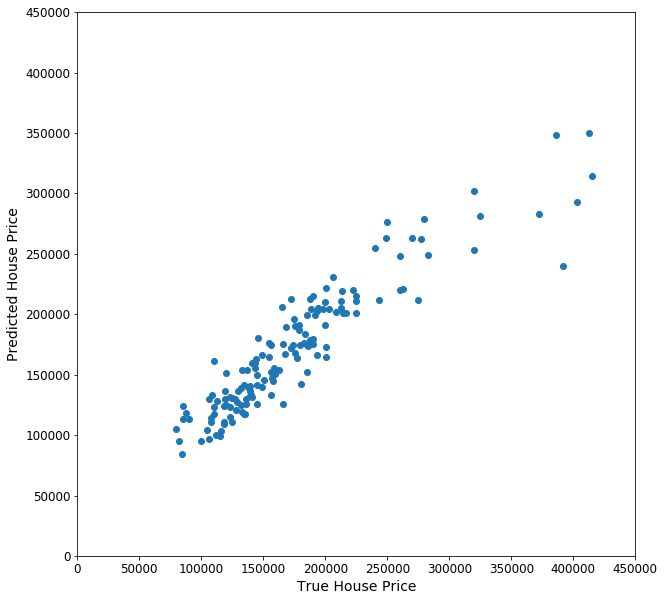

In [158]:
pred = lin_model.predict(X_test)
fig = plt.figure(figsize=(10, 10))
plt.scatter(np.exp(y_test), np.exp(pred))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.xlim(100, 450000)
plt.ylim(100, 450000)

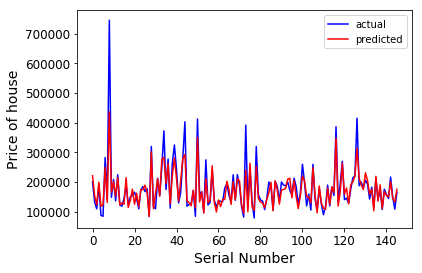

In [161]:
ind = pd.Series(range(0,len(np.exp(y_test))))
pldf = pd.DataFrame({"ind":ind.values, "actual":np.exp(y_test), "pred":np.exp(pred)})
ax = pldf.plot(kind="line",x='ind', y="actual", color="b", label="actual")
pldf.plot(kind="line", x='ind',y="pred", color="r", label="predicted", ax=ax)

ax.set_xlabel("Serial Number")
ax.set_ylabel("Price of house")
plt.show()

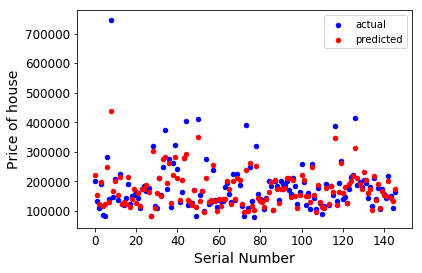

In [162]:
ax = pldf.plot(kind="scatter",x='ind', y="actual", color="b", label="actual")
pldf.plot(kind="scatter", x='ind',y="pred", color="r", label="predicted", ax=ax)

ax.set_xlabel("Serial Number")
ax.set_ylabel("Price of house")
plt.show()